# Bean Leaf Lesion Classification

**Model Architecture & Transfer Learning**
<br>For this three-class classification task, I employed the GoogLeNet (Inception v1) architecture. To maximize performance, I utilized Transfer Learning by initializing the model with ImageNet weights (weights='DEFAULT').
<br>eature Extractor: Unlike basic transfer learning where layers are frozen, I unfroze all convolutional layers for end-to-end fine-tuning. This allowed the model to adapt its pre-trained spatial hierarchies to the specific textures and color gradients of bean leaf lesions.
<br>Classification Head: The standard 1,000-class output was replaced with a single linear layer, mapping 1,024 deep features directly to the target classes: Healthy, Angular Leaf Spot, and Bean Rust.

**Optimization Strategy & Hyperparameters**
<br>The training pipeline was designed for high precision and regularization to prevent overfitting during the fine-tuning phase:
<br>Optimizer: I utilized AdamW (Adam with Decoupled Weight Decay) with a coefficient of 1e-4. This choice is superior to standard Adam for fine-tuning as it ensures more effective regularization.
<br>Learning Rate: A conservative rate of 1e-4 was maintained to ensure stable convergence without distorting the pre-trained weights too rapidly.
<br>Batch Size:4
<br>Data Augmentation: To improve AI Robustness, I implemented a sophisticated transformation pipeline:Resize (256x256) and Random Rotation (20°) to handle varied camera angles.Horizontal Flipping for spatial invariance.CenterCrop (224x224) to focus on the central lesion area, matching GoogLeNet’s expected input size.ImageNet Normalization for consistent pixel distribution.

**Performance Analysis**
<br>The model achieved state-of-the-art results for this dataset, demonstrating good generalization
* Training Accuracy - 97.29%
* Test Accuracy - 97.74%
  
The negligible gap between training and test accuracy indicates a highly robust model. The use of weight decay and data augmentation helped the model generalize the training samples.

In [147]:
import os
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import torch.optim as optim
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [148]:
train_df = pd.read_csv('/kaggle/input/datasets/marquis03/bean-leaf-lesions-classification/train.csv')
test_df = pd.read_csv('/kaggle/input/datasets/marquis03/bean-leaf-lesions-classification/val.csv')
train_df.head()

image:FILE  category
0   train/healthy/healthy_train.98.jpg         0
1  train/healthy/healthy_train.148.jpg         0
2  train/healthy/healthy_train.306.jpg         0
3  train/healthy/healthy_train.305.jpg         0
4   train/healthy/healthy_train.40.jpg         0

In [149]:
len(train_df)

1034

In [150]:
test_df.head()

image:FILE  category
0  val/healthy/healthy_val.25.jpg         0
1  val/healthy/healthy_val.32.jpg         0
2   val/healthy/healthy_val.3.jpg         0
3  val/healthy/healthy_val.16.jpg         0
4  val/healthy/healthy_val.10.jpg         0

In [151]:
train_df['category'].value_counts()

category
2    348
1    345
0    341
Name: count, dtype: int64

In [152]:
test_df['category'].value_counts()

category
2    45
0    44
1    44
Name: count, dtype: int64

In [153]:
from torch.utils.data import Dataset
import os
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        """
        Initializes the dataset object.
        dataframe: The Pandas DataFrame containing image paths and labels.
        transform: The transformation pipeline (Resize, Augmentation, Normalization).
        """
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        This is used by the DataLoader to know when an epoch is finished.
        """
        return len(self.dataframe)

    def __getitem__(self, idx):
        """
        Fetches a single data point (image and label) given an index.
        This method is called 'on-the-fly' during training.
        """
        # Access path and label using .iloc[row, col] to avoid FutureWarnings.
        # Column 0: Relative path | Column 1: Integer/String label.
        image_path = self.dataframe.iloc[idx, 0]
        label = self.dataframe.iloc[idx, 1]
        
        # Define the dataset root directory on Kaggle.
        base_path = '/kaggle/input/datasets/marquis03/bean-leaf-lesions-classification/'
        
        # Combine the base directory with the specific image path.
        full_path = os.path.join(base_path, image_path)
        
        # Load the image and ensure it is in 3-channel RGB format.
        # .convert('RGB') prevents issues with grayscale or alpha channel (RGBA) images.
        image = Image.open(full_path).convert('RGB')

        # Apply transformations (Data Augmentation or Normalization) if they exist.
        if self.transform:
            image = self.transform(image)

        # Return the processed image tensor and its corresponding label.
        return image, label

In [154]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomRotation(20),     
    transforms.RandomHorizontalFlip(), 
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

test_transform =  transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])

In [156]:
class_map = { 0: 'healthy' , 1:'angular_leaf_spot', 2: 'bean_rust' }
class_map

{0: 'healthy', 1: 'angular_leaf_spot', 2: 'bean_rust'}

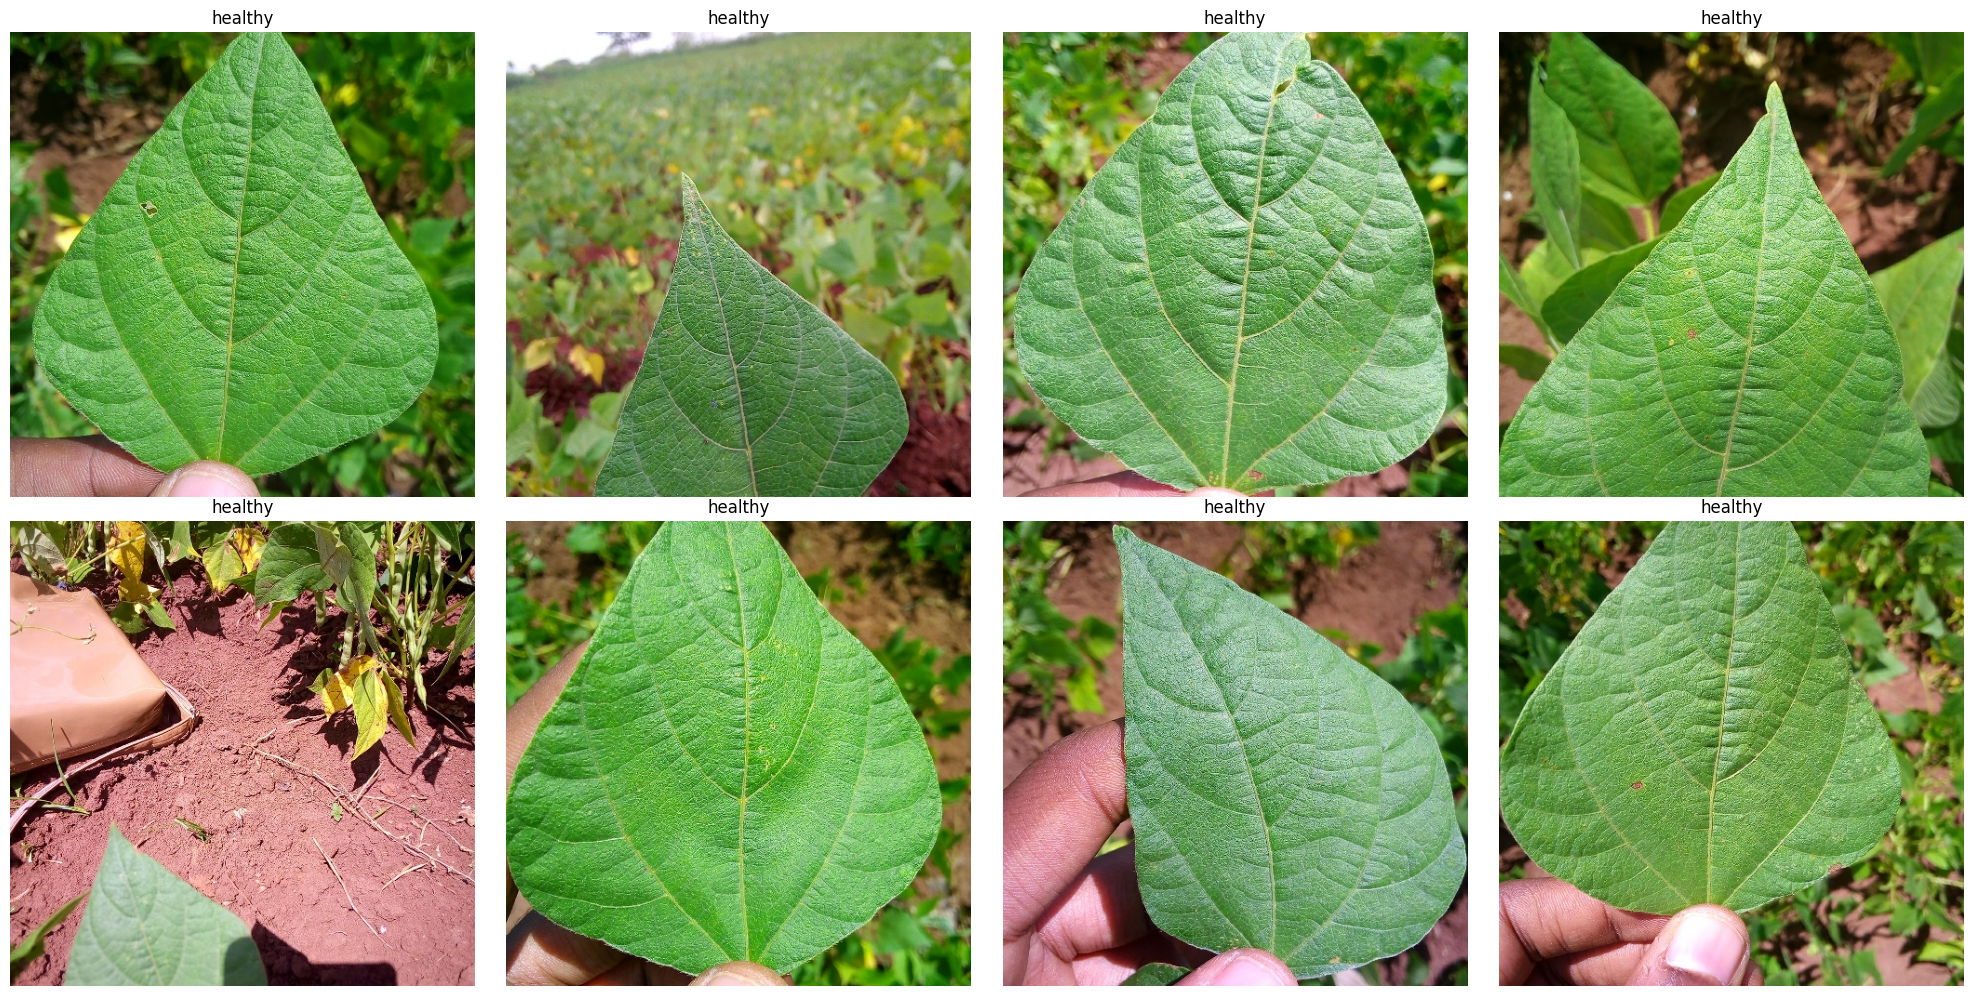

In [157]:
from PIL import Image, ImageOps

# Create a figure with 2 rows and 4 columns (total 8 subplots)
# figsize set to (20, 10) ensures the images are large enough to see lesion details
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

# Base directory where the Kaggle dataset is mounted
base_path = '/kaggle/input/datasets/marquis03/bean-leaf-lesions-classification/'

# Flatten the 2D array of axes into a 1D array for easy iteration (0 to 7)
axs_flat = axs.flatten()

for i, ax in enumerate(axs_flat):
    # Retrieve the relative image path from the first column of the DataFrame
    relative_path = train_df.iloc[i, 0]
    
    # Construct the absolute path required by the OS to locate the file
    full_path = os.path.join(base_path, relative_path)
    
    # Open the image and force it to RGB (removes alpha channels or grayscale issues)
    img = Image.open(full_path).convert('RGB')
    
    # Correct the orientation of the image based on its EXIF metadata
    # (Prevents images taken on phones from appearing rotated sideways)
    img = ImageOps.exif_transpose(img)
    
    # Fetch the numeric or string label from the second column
    label = train_df.iloc[i, 1]
    
    # Map the label to its human-readable class name (e.g., 0 -> 'Healthy')
    class_name = class_map[label]
    
    # Set the title of the subplot to the class name for visual verification
    ax.set_title(class_name)
    
    # Render the image on the specific subplot axis
    ax.imshow(img)
    
    # Remove the X and Y axis ticks/numbers for a cleaner look
    ax.axis('off')

# Automatically adjust the padding between subplots to prevent overlapping titles
plt.tight_layout()

# Display the final grid
plt.show()

In [158]:
# Create the training dataset object
# This combines our bean leaf images with the 'train_transform' (augmentation/normalization)
train_set = CustomDataset(train_df, transform=train_transform)

# Create the testing/validation dataset object
# We use 'test_transform' here, which only resizes and normalizes (no random flipping)
test_set = CustomDataset(test_df, transform=test_transform)

# Define how many images the model looks at before updating its internal weights
batch_size = 4

# The DataLoader for training:
# - shuffle=True: It mixes the images every epoch so the model doesn't learn the order of the data
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

# The DataLoader for testing:
# - shuffle=False: We don't need to mix the test data as we are just evaluating the final performance
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [159]:
# Check if a NVIDIA GPU is available and configured correctly with CUDA.
# If True, 'device' is set to 'cuda' for hardware acceleration.
# If False, it defaults to 'cpu'.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Output the string ('cuda' or 'cpu') to verify which hardware PyTorch is targeting.
print(f'Device: {device}')

Device: cuda


In [160]:
# 1. Load the pre-trained GoogLeNet architecture
# weights='DEFAULT' ensures you get the most up-to-date version trained on ImageNet
googlenet_model = models.googlenet(weights='DEFAULT')

# 2. Unfreeze the 'Backbone'
for params in googlenet_model.parameters():
    params.requires_grad = True

# 3. Define the new classification head
num_classes = 3 # Healthy, Angular Leaf Spot, and Bean Rust

# Replace the original 1000-class output layer with a new layer for our 3 bean categories
googlenet_model.fc = torch.nn.Linear(googlenet_model.fc.in_features, num_classes)

# 5. Move to Hardware Acceleration
googlenet_model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [161]:
googlenet_model.fc

Linear(in_features=1024, out_features=3, bias=True)

In [162]:
# 1. Define the Loss Function
criterion = nn.CrossEntropyLoss()

# 2. Define the Optimizer 
# Adamw is an advanced version of Gradient Descent.
optimizer = optim.AdamW(googlenet_model.parameters(), lr=1e-4, weight_decay=1e-4)
# # Split parameters into two groups
# backbone_params = [p for name, p in googlenet_model.named_parameters() if "fc" not in name]
# head_params = googlenet_model.fc.parameters()

# optimizer = optim.AdamW([
#     {'params': backbone_params, 'lr': 1e-5}, # 10x slower for pre-trained layers
#     {'params': head_params, 'lr': 1e-4}      # Standard speed for the new bean-classifier
# ], weight_decay=1e-4)


In [163]:
# Number of complete passes through the entire training dataset
epochs = 20

# Lists to track performance metrics over time for plotting later
total_train_loss, total_train_acc = [], []

for epoch in range(epochs):
    # --- TRAINING PHASE ---
    googlenet_model.train()  # Sets the model to training mode (enables Dropout/BatchNorm)
    running_train_loss = 0.0
    running_train_acc = 0
    
    for images, labels in train_loader:
        # Move a batch of data to the GPU (if available)
        images, labels = images.to(device), labels.to(device)
        
        # Forward Pass: Compute predictions
        outputs = googlenet_model(images)
        loss = criterion(outputs, labels)
        
        # Calculate Accuracy: Find the index of the highest logit
        preds = torch.argmax(outputs, dim=1)
        acc = (preds == labels).sum().item()
        
        # Accumulate metrics for the epoch
        running_train_loss += loss.item()
        running_train_acc += acc
        
        # Backward Pass: The optimization steps
        optimizer.zero_grad() # Clear previous gradients
        loss.backward()       # Compute new gradients (backpropagation)
        optimizer.step()      # Update weights based on gradients
        
   
    # --- EPOCH SUMMARY ---
    # Calculate average loss per batch and total accuracy for the dataset
    epoch_train_loss = running_train_loss / len(train_loader)
    epoch_train_acc = running_train_acc / len(train_set)
    # epoch_val_loss = running_val_loss / len(val_loader)
    # epoch_val_acc = running_val_acc / len(val_set)
    
    # Store results for visualization
    total_train_loss.append(epoch_train_loss) 
    total_train_acc.append(epoch_train_acc)

    
    # Print real-time progress
    print(f'Epoch: {epoch+1} | train loss: {epoch_train_loss:.4f} | train acc: {epoch_train_acc:.4f}')

Epoch: 1 | train loss: 0.6463 | train acc: 0.7389
Epoch: 2 | train loss: 0.3708 | train acc: 0.8646
Epoch: 3 | train loss: 0.3464 | train acc: 0.8810
Epoch: 4 | train loss: 0.3001 | train acc: 0.8897
Epoch: 5 | train loss: 0.2680 | train acc: 0.9101
Epoch: 6 | train loss: 0.2246 | train acc: 0.9323
Epoch: 7 | train loss: 0.1865 | train acc: 0.9323
Epoch: 8 | train loss: 0.1576 | train acc: 0.9526
Epoch: 9 | train loss: 0.1967 | train acc: 0.9429
Epoch: 10 | train loss: 0.1498 | train acc: 0.9594
Epoch: 11 | train loss: 0.1441 | train acc: 0.9603
Epoch: 12 | train loss: 0.1246 | train acc: 0.9671
Epoch: 13 | train loss: 0.1492 | train acc: 0.9584
Epoch: 14 | train loss: 0.1192 | train acc: 0.9632
Epoch: 15 | train loss: 0.1018 | train acc: 0.9758
Epoch: 16 | train loss: 0.1086 | train acc: 0.9681
Epoch: 17 | train loss: 0.1191 | train acc: 0.9623
Epoch: 18 | train loss: 0.0945 | train acc: 0.9729
Epoch: 19 | train loss: 0.0685 | train acc: 0.9797
Epoch: 20 | train loss: 0.0793 | train a

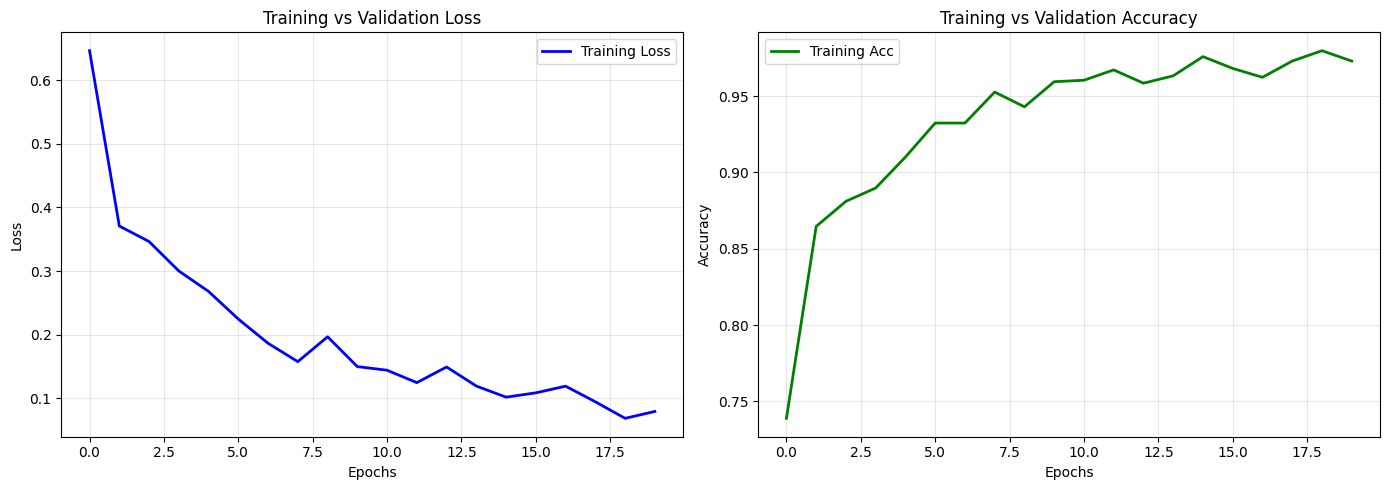

In [164]:
# Create a figure with two subplots
plt.figure(figsize=(14, 5))

# --- Plot 1: Loss ---
plt.subplot(1, 2, 1)
plt.plot(total_train_loss, label='Training Loss', color='blue', lw=2)
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# --- Plot 2: Accuracy ---
plt.subplot(1, 2, 2)
plt.plot(total_train_acc, label='Training Acc', color='green', lw=2)
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [165]:
# --- FINAL TEST EVALUATION ---
# Set the model to evaluation mode. This ensures consistent behavior 
# (e.g., if you later add Dropout, it will be disabled here).
googlenet_model.eval()

running_test_loss = 0.0
running_test_acc = 0

# These lists will store every single prediction and true label for 
# detailed post-hoc analysis (like confusion matrices).
total_preds = []
total_labels = []

# 'no_grad' disables the gradient tracking engine, reducing memory 
# usage and speeding up the computation during inference.
with torch.no_grad():
    for images, labels in test_loader:
        # Move the test batch to the GPU
        images, labels = images.to(device), labels.to(device)
        
        # Forward Pass: Get the model's raw scores (logits)
        outputs = googlenet_model(images)
        loss = criterion(outputs, labels)
        
        # Determine the predicted class index for each image in the batch
        preds = torch.argmax(outputs, dim=1)
        
        # Calculate how many predictions in this batch were correct
        acc = (preds == labels).sum().item()
        
        # Accumulate the loss and accuracy metrics
        running_test_loss += loss.item()
        running_test_acc += acc
        
        # Move data back to CPU and convert to NumPy for storage in our lists.
        # This is necessary because NumPy cannot live on the GPU.
        total_preds.extend(preds.cpu().numpy())
        total_labels.extend(labels.cpu().numpy())

# Calculate the final average loss per batch and overall accuracy percentage
total_test_loss = running_test_loss / len(test_loader)
total_test_acc = running_test_acc / len(test_set)

print(f'Test loss: {total_test_loss:.4f} | Test acc: {total_test_acc:.4f}')

Test loss: 0.0601 | Test acc: 0.9774


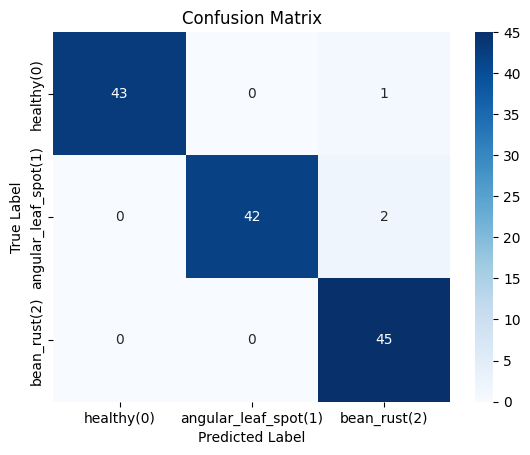

In [166]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Generate the confusion matrix values by comparing the true labels 
# against the model's predictions.
cm = confusion_matrix(total_labels, total_preds)

# Create a heatmap to visualize the matrix.
# xticklabels/yticklabels: Maps the encoded labels back to original class labels.
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['healthy(0)', 'angular_leaf_spot(1)', 'bean_rust(2)'], 
            yticklabels=['healthy(0)', 'angular_leaf_spot(1)', 'bean_rust(2)'])
# Add descriptive labels for the axes.
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Display the final plot.
plt.show()